In [3]:
!pip install vectorbt
!pip install ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1a6335fdf07b85c089811f5fd9f4ad61056981873508400a32961d08ef061ccd
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


=====================================================================

#Simplified SMA + RSI Strategy with Robustness Checks

=====================================================================

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
import ta
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,6)

# 1) Load Data


/tmp/ipython-input-266391520.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Data for AAPL from 2021-01-01 to 2023-01-01
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2021-01-04  126.096573  130.189033  123.514422  130.101340  143301900
2021-01-05  127.655594  128.366914  125.141651  125.589879   97664900
2021-01-06  123.358543  127.694610  123.144175  124.449870  155088000
2021-01-07  127.567917  128.259745  124.586268  125.073466  109578200
2021-01-08  128.668991  129.234143  126.895583  129.039251  105158200

Summary Statistics:
Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   503.000000  503.000000  503.000000  503.000000  5.030000e+02
mean    145.031484  146.713774  143.237482  144.953038  8.922010e+07
std      15.412619   15.576759   15.192674   15.360662  2.658359e+07
min     113.550125  117.492588

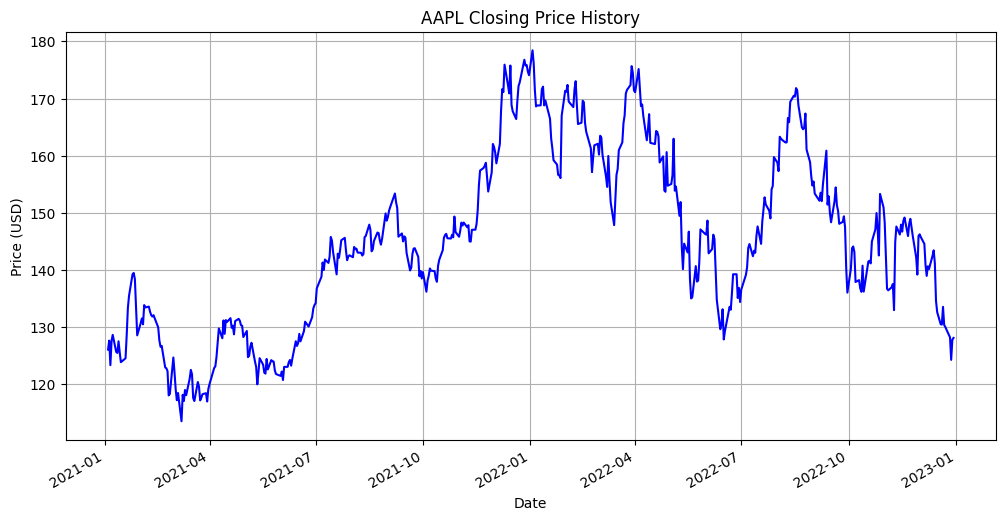

In [20]:
ticker = "AAPL"
start_date = "2021-01-01"
end_date   = "2023-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
close = pd.Series(data['Close'].squeeze(), index=data.index, name='Close')

print(f"Data for {ticker} from {start_date} to {end_date}")
print(data.head())

print("\nSummary Statistics:")
print(data.describe())

close.plot(title=f"{ticker} Closing Price History", grid=True, color='blue')
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.show()


# 2) Optimization Function


In [33]:
def backtest_sma_rsi(close_series, short_w, long_w, rsi_low, rsi_high, init_cash=100000, fees=0.001):
    sma_short = close_series.rolling(int(short_w)).mean()
    sma_long  = close_series.rolling(int(long_w)).mean()
    rsi = ta.momentum.RSIIndicator(close_series, window=14).rsi()

    entries = (sma_short > sma_long) & (rsi < rsi_low)
    exits   = (sma_short < sma_long) | (rsi > rsi_high)

    pf = vbt.Portfolio.from_signals(
        close=close_series,
        entries=entries,
        exits=exits,
        init_cash=init_cash,
        fees=fees,
        freq='1D'
    )
    return pf

def optimize_on_close(close_series, short_windows, long_windows, rsi_lows, rsi_highs,
                      min_trades=10, init_cash=100000, fees=0.001):
    results = []
    for short_w in short_windows:
        for long_w in long_windows:
            if short_w >= long_w:
                continue
            for rsi_low in rsi_lows:
                for rsi_high in rsi_highs:
                    pf = backtest_sma_rsi(close_series, short_w, long_w, rsi_low, rsi_high, init_cash, fees)
                    stats = pf.stats()
                    results.append({
                        'short_w': short_w,
                        'long_w': long_w,
                        'rsi_low': rsi_low,
                        'rsi_high': rsi_high,
                        'sharpe': stats.get('Sharpe Ratio', np.nan),
                        'total_return': stats.get('Total Return [%]', np.nan),
                        'max_dd': stats.get('Max Drawdown [%]', np.nan),
                        'trades': stats.get('Total Closed Trades', 0)
                    })

    df = pd.DataFrame(results)
    print(f"\nTotal strategies tested: {len(df)}")
    print("Trade count distribution:\n", df['trades'].describe())

    filtered = df[df['trades'] >= min_trades]
    if filtered.empty:
        print(f"\n⚠️ No strategies met min_trades={min_trades}. Showing best available without filter.")
        df_sel = df[df['trades'] > 0] if not df.empty else df
    else:
        df_sel = filtered

    # Blended score: Sharpe × sqrt(trades)
    df_sel = df_sel.assign(score=df_sel['sharpe'] * np.sqrt(np.maximum(df_sel['trades'], 1)))
    best = df_sel.sort_values(by='score', ascending=False).iloc[0]
    return best, df.sort_values(by='sharpe', ascending=False)

def print_performance_interpretation(stats_series):
    sr = stats_series.get('Sharpe Ratio', np.nan)
    tr = stats_series.get('Total Return [%]', np.nan) / 100
    ntr = stats_series.get('Total Closed Trades', 0)

    print("\nPERFORMANCE INTERPRETATION:")
    if sr > 1.0:
        print("EXCELLENT: Sharpe ratio > 1.0 — strong risk-adjusted returns.")
    elif sr > 0.5:
        print("GOOD: Sharpe ratio > 0.5 — decent risk-adjusted returns.")
    elif sr > 0:
        print("MODERATE: Positive Sharpe ratio — could be improved.")
    else:
        print("POOR: Negative Sharpe ratio — underperforms on a risk-adjusted basis.")

    if tr > 0.10:
        print("HIGHLY PROFITABLE: Returns > 10% over the test period.")
    elif tr > 0.05:
        print("PROFITABLE: Returns > 5% over the test period.")
    elif tr > 0:
        print("BREAK-EVEN: Small positive returns.")
    else:
        print("LOSS: Negative returns.")

    if ntr >= 20:
        print(f"ACTIVE: {ntr} trades — good sample size.")
    elif ntr >= 10:
        print(f"LOW FREQUENCY: {ntr} trades — moderately robust.")
    elif ntr >= 5:
        print(f"LOW FREQUENCY: {ntr} trades — may lack robustness.")
    else:
        print(f"VERY LOW FREQUENCY: Only {ntr} trades — high overfitting risk.")

# 3) Single Optimization Run

In [22]:
short_windows = np.arange(5, 80, 5)
long_windows  = np.arange(30, 250, 10)
rsi_lows      = np.arange(30, 55, 5)
rsi_highs     = np.arange(50, 70, 5)

best, df_ranked = optimize_on_close(
    close_series=close,
    short_windows=short_windows,
    long_windows=long_windows,
    rsi_lows=rsi_lows,
    rsi_highs=rsi_highs,
    min_trades=10
)

print("\nBest Parameters:")
print(best)


Total strategies tested: 6000
Trade count distribution:
 count    6000.000000
mean        4.066000
std         2.811576
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        17.000000
Name: trades, dtype: float64

Best Parameters:
short_w         30.000000
long_w          40.000000
rsi_low         40.000000
rsi_high        50.000000
sharpe           0.666438
total_return    11.541456
max_dd           7.702660
trades          10.000000
score            2.107463
Name: 2208, dtype: float64


# 4) Best Strategy

In [34]:
print_performance_interpretation(stats_best)

pf_best.plot().show()


PERFORMANCE INTERPRETATION:
GOOD: Sharpe ratio > 0.5 — decent risk-adjusted returns.
HIGHLY PROFITABLE: Returns > 10% over the test period.
LOW FREQUENCY: 10 trades — moderately robust.


=====================================================================
# Mock Trading Environment
=====================================================================

In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta

# 1. Parameters

In [25]:
initial_cash = 100000
tickers = ["AAPL", "MSFT", "GOOGL"]
start_date = "2021-01-01"
end_date = "2023-01-01"
risk_free_rate = 0.02

# 2. Load Data

In [26]:
data = yf.download(tickers, start=start_date, end=end_date)["Close"]

/tmp/ipython-input-1586094343.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  3 of 3 completed


# 3. Backtest Function

In [27]:
def run_strategy(data, short_w, long_w, rsi_low, rsi_high):
    cash = initial_cash
    positions = {t: 0 for t in tickers}
    portfolio_values = []

    # Precompute indicators per ticker
    sma_short = {}
    sma_long = {}
    rsi = {}
    for t in tickers:
        sma_short[t] = data[t].rolling(short_w).mean()
        sma_long[t] = data[t].rolling(long_w).mean()
        rsi[t] = ta.momentum.RSIIndicator(data[t], window=14).rsi()

    for date in data.index:
        prices = data.loc[date]
        for t in tickers:
            price = prices[t]
            if np.isnan(price) or np.isnan(sma_short[t].loc[date]) or np.isnan(rsi[t].loc[date]):
                continue

            # Buy
            if sma_short[t].loc[date] > sma_long[t].loc[date] and rsi[t].loc[date] < rsi_low and cash > price:
                shares = int(cash // price // len(tickers))
                if shares > 0:
                    positions[t] += shares
                    cash -= shares * price

            # Sell
            elif sma_short[t].loc[date] < sma_long[t].loc[date] or rsi[t].loc[date] > rsi_high:
                if positions[t] > 0:
                    cash += positions[t] * price
                    positions[t] = 0

        total_value = cash + sum(positions[t] * prices[t] for t in tickers)
        portfolio_values.append(total_value)

    df_portfolio = pd.DataFrame({"Value": portfolio_values}, index=data.index)
    df_portfolio["Returns"] = df_portfolio["Value"].pct_change()

    total_return = df_portfolio["Value"].iloc[-1] / initial_cash - 1
    days = (df_portfolio.index[-1] - df_portfolio.index[0]).days
    annualized_return = (1 + total_return) ** (365 / days) - 1
    excess_daily = df_portfolio["Returns"] - (risk_free_rate / 252)
    sharpe = np.sqrt(252) * excess_daily.mean() / excess_daily.std()

    return {
        "short_w": short_w,
        "long_w": long_w,
        "rsi_low": rsi_low,
        "rsi_high": rsi_high,
        "total_return": total_return,
        "annualized_return": annualized_return,
        "sharpe": sharpe,
        "final_value": df_portfolio["Value"].iloc[-1]
    }

# 4. Parameter Optimization

In [28]:
results = []
short_windows = [5, 10, 20, 30]
long_windows = [50, 100, 150]
rsi_lows = [30, 35, 40]
rsi_highs = [60, 65, 70]

for sw in short_windows:
    for lw in long_windows:
        if sw >= lw:
            continue
        for rl in rsi_lows:
            for rh in rsi_highs:
                res = run_strategy(data, sw, lw, rl, rh)
                results.append(res)

df_results = pd.DataFrame(results)
df_results["score"] = df_results["sharpe"] * np.sqrt(abs(df_results["total_return"] + 1))
best = df_results.sort_values(by="score", ascending=False).iloc[0]

print("Best Parameters Found:")
print(best)

Best Parameters Found:
short_w                  20.000000
long_w                   50.000000
rsi_low                  35.000000
rsi_high                 60.000000
total_return              0.107064
annualized_return         0.052540
sharpe                    0.524673
final_value          110706.447845
score                     0.552046
Name: 57, dtype: float64


# 5. Trading plan based on Analysis

In [45]:
final_res = run_strategy(data, int(best["short_w"]), int(best["long_w"]), int(best["rsi_low"]), int(best["rsi_high"]))

# Calculate total P&L
total_pnl = best['final_value'] - initial_cash

print("\nOptimized Strategy Performance:")
print(f"Final Portfolio Value: ${final_res['final_value']:.2f}")
print(f"Total Return: {final_res['total_return']*100:.2f}%")
print(f"Total Profit/Loss: ${total_pnl:,.2f}")
print(f"Annualized Return: {final_res['annualized_return']*100:.2f}%")
print(f"Sharpe Ratio: {final_res['sharpe']:.2f}")

# --- Trading Plan ---
print("\n📋 Trading Plan:")
print(f"BUY  when {int(final_res['short_w'])}-day SMA > {int(best['long_w'])}-day SMA AND RSI < {int(final_res['rsi_low'])}")
print(f"SELL when {int(final_res['short_w'])}-day SMA < {int(best['long_w'])}-day SMA OR RSI > {int(final_res['rsi_high'])}")
print("HOLD otherwise.")


Optimized Strategy Performance:
Final Portfolio Value: $110706.45
Total Return: 10.71%
Total Profit/Loss: $10,706.45
Annualized Return: 5.25%
Sharpe Ratio: 0.52

📋 Trading Plan:
BUY  when 20-day SMA > 50-day SMA AND RSI < 35
SELL when 20-day SMA < 50-day SMA OR RSI > 60
HOLD otherwise.
